In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
gpu = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpu[0],True)

In [4]:
data = np.load("D:/Study/GreatLearning/7.ComputerVision/Project/images.npy")

In [5]:
data.shape

(4750, 128, 128, 3)

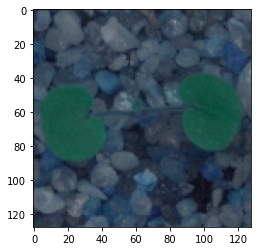

In [6]:
plt.imshow(data[0])

In [7]:
data = data/255.0

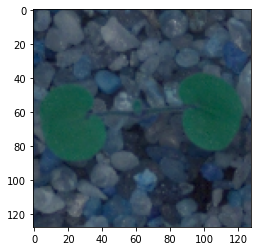

In [8]:
plt.imshow(data[0])

In [9]:
data.shape

(4750, 128, 128, 3)

In [10]:
#blur = np.empty(data.shape)

In [11]:
#blur.shape

In [12]:
#for i, img in enumerate(data):
 #data[i] = cv2.GaussianBlur(img, (3, 3), 0)

In [13]:
data.shape

(4750, 128, 128, 3)

In [14]:
labels = pd.read_csv("Labels.csv")

In [15]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [16]:
labels.iloc[0,:]

Label    Small-flowered Cranesbill
Name: 0, dtype: object

Text(0.5, 1.0, 'Charlock')

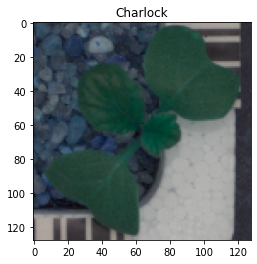

In [17]:
plt.imshow(data[2336])
plt.title(labels.iloc[2336,0])

Text(0.5, 1.0, 'Shepherds Purse')

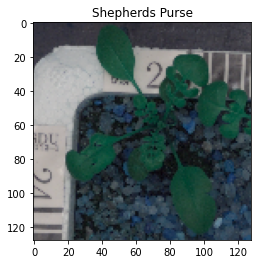

In [18]:
plt.imshow(data[1002])
plt.title(labels.iloc[1002,0])

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
le = LabelEncoder()

In [21]:
labels_le = le.fit_transform(labels)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [22]:
labels_le

array([10, 10, 10, ...,  6,  6,  6])

In [23]:
le.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
xtr, xtsf, ytr, ytsf = train_test_split(data, labels_le, test_size=0.3, stratify=labels_le)

In [26]:
xtv, xts, ytv, yts = train_test_split(xtsf, ytsf, test_size=0.5, stratify=ytsf)

In [27]:
xtr.shape, xtv.shape, xts.shape

((3325, 128, 128, 3), (712, 128, 128, 3), (713, 128, 128, 3))

In [28]:
from functools import partial
from tensorflow import keras

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=7, input_shape=xtr.shape[1:]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=10),
    DefaultConv2D(filters=5),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=60, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=30, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=12, activation='softmax'),
])

In [29]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(xtr, ytr, batch_size=50,epochs=1000, validation_split=0.1, callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True))

Epoch 1/1000
60/60 [==============================] - 5s 37ms/step - loss: 2.4712 - accuracy: 0.1091 - val_loss: 2.4438 - val_accuracy: 0.1321
Epoch 2/1000
60/60 [==============================] - 1s 19ms/step - loss: 2.4481 - accuracy: 0.1216 - val_loss: 2.4391 - val_accuracy: 0.1381
Epoch 3/1000
60/60 [==============================] - 1s 18ms/step - loss: 2.4381 - accuracy: 0.1437 - val_loss: 2.4350 - val_accuracy: 0.1381
Epoch 4/1000
60/60 [==============================] - 1s 18ms/step - loss: 2.4300 - accuracy: 0.1279 - val_loss: 2.4378 - val_accuracy: 0.1381
Epoch 5/1000
60/60 [==============================] - 1s 18ms/step - loss: 2.4322 - accuracy: 0.1307 - val_loss: 2.4329 - val_accuracy: 0.1381
Epoch 6/1000
60/60 [==============================] - 1s 18ms/step - loss: 2.4239 - accuracy: 0.1377 - val_loss: 2.4320 - val_accuracy: 0.1381
Epoch 7/1000
60/60 [==============================] - 1s 18ms/step - loss: 2.4314 - accuracy: 0.1120 - val_loss: 2.4329 - val_accuracy: 0.1381

In [30]:
model.evaluate(xts,yts)

23/23 [==============================] - 0s 8ms/step - loss: 2.4153 - accuracy: 0.1374


[2.4153339862823486, 0.13744740188121796]

<AxesSubplot:>

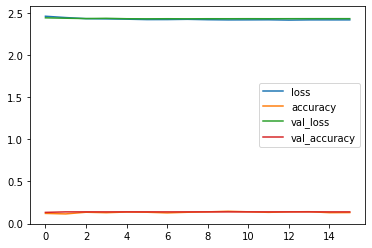

In [31]:
hi1 = pd.DataFrame(history.history)
hi1.plot()

In [32]:
#ResNet-34

from functools import partial
import tensorflow.keras as keras

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [33]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=xtr.shape[1:]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(12, activation="softmax"))

In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(xtr, ytr, batch_size=50,epochs=1000, validation_split=0.2, callbacks=tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True))

Epoch 1/1000
54/54 [==============================] - 8s 89ms/step - loss: 3.2890 - accuracy: 0.2272 - val_loss: 82053.7344 - val_accuracy: 0.1489
Epoch 2/1000
54/54 [==============================] - 4s 67ms/step - loss: 1.4119 - accuracy: 0.5198 - val_loss: 143.8835 - val_accuracy: 0.1489
Epoch 3/1000
54/54 [==============================] - 4s 67ms/step - loss: 1.1971 - accuracy: 0.6084 - val_loss: 2051.1245 - val_accuracy: 0.1489
Epoch 4/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.9207 - accuracy: 0.7066 - val_loss: 152.7707 - val_accuracy: 0.1519
Epoch 5/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.7519 - accuracy: 0.7385 - val_loss: 44.0142 - val_accuracy: 0.1594
Epoch 6/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.7231 - accuracy: 0.7488 - val_loss: 12.4530 - val_accuracy: 0.1729
Epoch 7/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.6177 - accuracy: 0.7874 - val_loss: 67.8388 - val_ac

Epoch 58/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.0364 - accuracy: 0.9863 - val_loss: 1.5240 - val_accuracy: 0.7774
Epoch 59/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.0403 - accuracy: 0.9892 - val_loss: 0.9434 - val_accuracy: 0.8075
Epoch 60/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.1029 - accuracy: 0.9685 - val_loss: 1.0508 - val_accuracy: 0.7729
Epoch 61/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.0457 - accuracy: 0.9849 - val_loss: 0.6345 - val_accuracy: 0.8737
Epoch 62/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.6645 - val_accuracy: 0.8692
Epoch 63/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.0103 - accuracy: 0.9974 - val_loss: 1.4067 - val_accuracy: 0.7654
Epoch 64/1000
54/54 [==============================] - 4s 67ms/step - loss: 0.0197 - accuracy: 0.9926 - val_loss: 1.0046 - val_accuracy:

<AxesSubplot:>

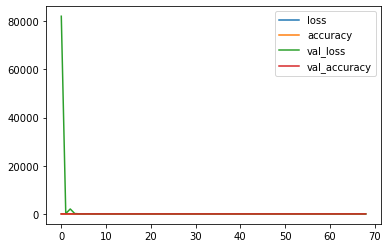

In [35]:
hi2 = pd.DataFrame(history.history)
hi2.plot()

In [36]:
model.evaluate(xts,yts)

23/23 [==============================] - 1s 23ms/step - loss: 0.5788 - accuracy: 0.8626


[0.5788262486457825, 0.8625525832176208]

In [37]:
def predict_probas(model, X, n_samples=10):
  y_probs = [model.predict(X) for sample in range(n_samples)]
  return np.mean(y_probs, axis=0)

def predict_classes(model, X, n_samples=10):
  y_probs = predict_probas(model, X, n_samples)
  return np.argmax(y_probs, axis=1)

In [38]:
y_pred = predict_classes(model, xts)

In [39]:
accuracy = np.mean(y_pred == yts)
accuracy

0.8625525946704067

Text(0.5, 117.59999999999997, 'Predict')

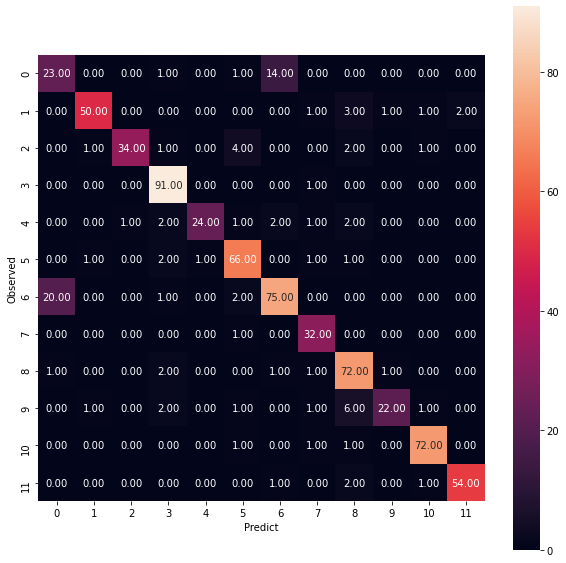

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(yts,y_pred),annot=True, fmt=".2f", xticklabels=range(12),yticklabels=range(12),square=True)
plt.ylabel("Observed")
plt.xlabel("Predict")

In [41]:
# Trying input augumentation

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
#ResNet-34 Model 2

model2 = keras.models.Sequential()
model2.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=xtr.shape[1:]))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("relu"))
model2.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model2.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model2.add(keras.layers.GlobalAvgPool2D())
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(12, activation="softmax"))
model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [44]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(data)

In [45]:
batch = 32

history = model2.fit_generator(datagen.flow(xtr,ytr,batch_size=batch),epochs = 100, validation_data = (xtv,ytv),
                              verbose = 1, steps_per_epoch=len(xtr) // batch,
                              callbacks=tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True))

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1847: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
103/103 [==============================] - 13s 100ms/step - loss: 3.0452 - accuracy: 0.2897 - val_loss: 5.7464 - val_accuracy: 0.0562
Epoch 2/100
103/103 [==============================] - 9s 91ms/step - loss: 1.3698 - accuracy: 0.5385 - val_loss: 6.2545 - val_accuracy: 0.1390
Epoch 3/100
103/103 [==============================] - 9s 91ms/step - loss: 1.1157 - accuracy: 0.6122 - val_loss: 3.9705 - val_accuracy: 0.2528
Epoch 4/100
103/103 [==============================] - 9s 91ms/step - loss: 0.8870 - accuracy: 0.6979 - val_loss: 4.0946 - val_accuracy: 0.2683
Epoch 5/100
103/103 [==============================] - 9s 91ms/step - loss: 0.8480 - accuracy: 0.7175 - val_loss: 1.9396 - val_accuracy: 0.5815
Epoch 6/100
103/103 [==============================] - 9s 91ms/step - loss: 0.7347 - accuracy: 0.7548 - val_loss: 1.6715 - val_accuracy: 0.5688
Epoch 7/100
103/103 [==============================] - 9s 91ms/step - loss: 0.7017 - accuracy: 0.7679 - val_loss: 1.5547 - val_accurac

103/103 [==============================] - 9s 91ms/step - loss: 0.0976 - accuracy: 0.9627 - val_loss: 2.2748 - val_accuracy: 0.5758
Epoch 58/100
103/103 [==============================] - 9s 91ms/step - loss: 0.0837 - accuracy: 0.9689 - val_loss: 1.3142 - val_accuracy: 0.7556
Epoch 59/100
103/103 [==============================] - 9s 91ms/step - loss: 0.1026 - accuracy: 0.9651 - val_loss: 1.3825 - val_accuracy: 0.7233


<AxesSubplot:>

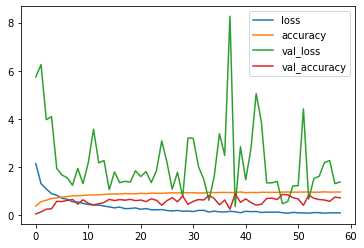

In [46]:
hi3 = pd.DataFrame(history.history)
hi3.plot()

In [47]:
model.evaluate(xts,yts)

23/23 [==============================] - 0s 16ms/step - loss: 0.5788 - accuracy: 0.8626


[0.5788262486457825, 0.8625525832176208]

In [48]:
model2.evaluate(xts,yts)

23/23 [==============================] - 0s 16ms/step - loss: 0.3153 - accuracy: 0.9060


[0.3153080940246582, 0.9060308337211609]

In [49]:
y_pred2 = predict_classes(model2, xts)

Text(0.5, 117.59999999999997, 'Predict')

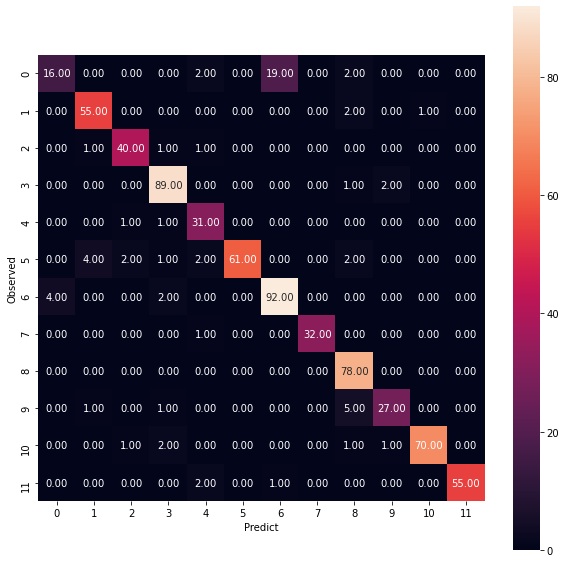

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(yts,y_pred2),annot=True, fmt=".2f", xticklabels=range(12),yticklabels=range(12),square=True)
plt.ylabel("Observed")
plt.xlabel("Predict")

In [51]:
#VGG-16

In [52]:
from tensorflow.keras import applications

In [53]:
vgg16_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=xtr.shape[1:])

In [54]:
add_model = tf.keras.models.Sequential()
add_model.add(tf.keras.layers.Flatten(input_shape=vgg16_model.output_shape[1:]))
add_model.add(tf.keras.layers.Dense(256, activation='relu'))
add_model.add(tf.keras.layers.Dense(12, activation='softmax'))

model3 = tf.keras.Model(inputs=vgg16_model.input, outputs=add_model(vgg16_model.output))
model3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [55]:
batch = 32

history = model3.fit(datagen.flow(xtr,ytr,batch_size=batch),epochs = 100, validation_data = (xtv,ytv),
                              verbose = 1, steps_per_epoch=len(xtr) // batch,
                              callbacks=tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True))

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[512,512,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block5_conv1/Relu (defined at <ipython-input-55-2136b190c4aa>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_58707]

Function call stack:
train_function


In [ ]:
hi4 = pd.DataFrame(history.history)
hi4.plot()

In [ ]:
model.evaluate(xts,yts)

In [ ]:
model2.evaluate(xts,yts)

In [ ]:
model3.evaluate(xts,yts)

In [ ]:
y_pred3 = predict_classes(model3, xts)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(yts,y_pred3),annot=True, fmt=".2f", xticklabels=range(12),yticklabels=range(12),square=True)
plt.ylabel("Observed")
plt.xlabel("Predict")